Dependencies and Imports

In [372]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import json
import networkx as nx
import matplotlib.pyplot as plt
from libpysal import weights, examples
from haversine import haversine, Unit
from scipy.spatial import KDTree

In [655]:
ddb = gpd.read_file('./data/ddb_roundabout.geojson')
roads = gpd.read_file('./data/roundaboutv3.geojson')

In [751]:
ddb = ddb.to_crs(4326)
roads = roads.to_crs(4326)

In [124]:
def check_graph(nxgraph):
    # Check if the graph has any nodes.
    print("Graph nodes:")
    if nxgraph.number_of_nodes() > 0:
        print("The graph has nodes.")
        #count number of nodes
        print("Number of nodes:", nxgraph.number_of_nodes())
    else:
        print("The graph does not have any nodes.")
    # Check if the graph has any edges.
    print("\nGraph edges:")
    if nxgraph.number_of_edges() > 0:
        print("The graph has edges.")
        #count number of edges
        print("Number of edges:", nxgraph.number_of_edges())
    else:
        print("The graph does not have any edges.")
    # Check if the graph is connected.
    print("\nGraph connection:")
    if nx.is_connected(nxgraph):
        print("The graph is connected.")
    else:
        print("The graph is disconnected.")
        

Graph for coordinates of DDB

https://networkx.org/documentation/stable/auto_examples/geospatial/plot_points.html
https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html
https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html

Examples:

https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html
https://networkx.org/nx-guides/content/generators/geometric.html

DDB Only

In [303]:
ddb_coordinates = np.column_stack((ddb.geometry.x, ddb.geometry.y))
dist = weights.DistanceBand.from_array(ddb_coordinates, threshold=1000)
incidents = dist.to_networkx()
incident_loc = dict(zip(incidents.nodes, ddb_coordinates))
incidents.remove_edges_from(list(incidents.edges()))

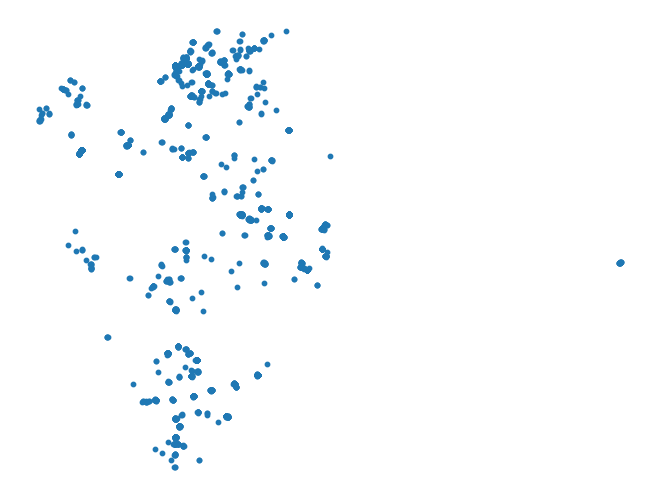

In [304]:
nx.draw(incidents, incident_loc, node_size=10)
plt.show()

In [230]:
check_graph(incidents)

Graph nodes:
The graph has nodes.
Number of nodes: 2167

Graph edges:
The graph does not have any edges.

Graph connection:
The graph is disconnected.


Roundabouts Only

In [305]:
centres = np.column_stack((roads.centroid.x, roads.centroid.y))
queen = weights.Queen.from_dataframe(roads)
roundgraph = queen.to_networkx()
positions = dict(zip(roundgraph.nodes, centres))
roundgraph.remove_edges_from(list(roundgraph.edges()))

C:\Users\User\AppData\Local\Temp\ipykernel_75396\3504636887.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centres = np.column_stack((roads.centroid.x, roads.centroid.y))
C:\Users\User\AppData\Local\Temp\ipykernel_75396\3504636887.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(roads)
c:\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 463 disconnected components.
 There are 355 islands with ids: 0, 1, 2, 3, 9, 14, 16, 21, 22, 24, 25, 30, 31, 32, 33, 34, 49, 50, 51, 54, 55, 56, 57, 58, 61, 62, 65, 67, 68, 69, 71, 72, 76, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 94, 95, 100, 101, 102, 104, 105, 106, 107, 108, 109, 11

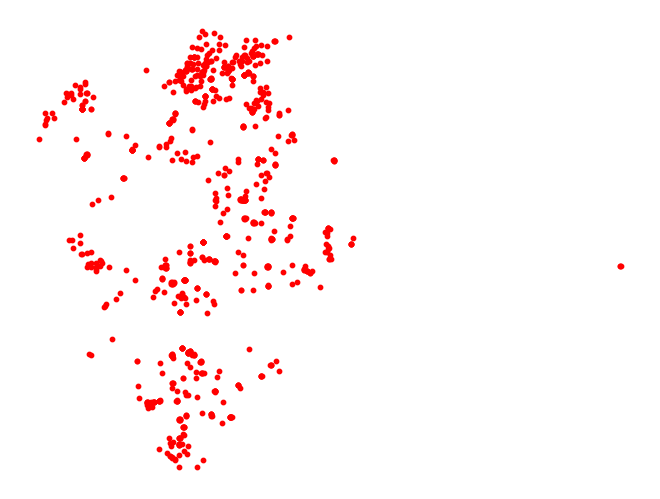

In [306]:
nx.draw(roundgraph, positions, node_size=10, node_color="r")
plt.show()

In [256]:
check_graph(roundgraph)

Graph nodes:
The graph has nodes.
Number of nodes: 904

Graph edges:
The graph does not have any edges.

Graph connection:
The graph is disconnected.


Combined Graph

In [564]:
"""
change colors to represent either ddb or roundabout node /
attach prefixes to columns of each dataset first /
take the nodes directly from the dataset instead /
then connect edges based on harvesine formula (nearest 100m maybe?) /
then send email to professor about results

look for another method to connect edges other than distance
connect edges based on this method
send update to professor
"""

'\nchange colors to represent either ddb or roundabout node /\nattach prefixes to columns of each dataset first /\ntake the nodes directly from the dataset instead /\nthen connect edges based on harvesine formula (nearest 100m maybe?) /\nthen send email to professor about results\n\nlook for another method to connect edges other than distance\nconnect edges based on this method\nsend update to professor\n'

In [803]:
combined_graph = nx.Graph()

In [804]:
#adding base nodes and base positions to graph
ddb_nodes = ddb.nodes
roundabout_nodes = roads.nodes

combined_graph.add_nodes_from(ddb_nodes)
combined_graph.add_nodes_from(roundabout_nodes)

combined_coordinates = np.concatenate([ddb_coordinates, centres])
combined_pos = dict(zip(combined_graph.nodes, combined_coordinates))

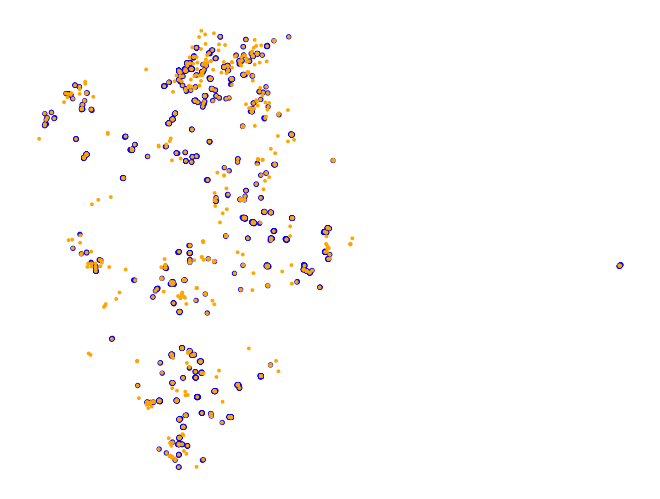

In [805]:
#drawing base graphs with nodes and positions
color_map = {
    'ddb': 'blue',
    'r': 'orange',
}
colors = [color_map[node.split('_')[0]] for node in combined_graph.nodes]
sizes = [8 if color == 'blue' else 3 for color in colors]

nx.draw(combined_graph, combined_pos, node_size=sizes, node_color=colors)
plt.show()

In [740]:
def haversine_dist(point_node, polygon_node):
    point1 = (point_node.y, point_node.x)
    point2 = (polygon_node.centroid.y, polygon_node.centroid.x)
    return haversine(point1, point2, unit=Unit.METERS, normalize=True)

In [739]:
def haversine_dist_poly(poly1, poly2):
    point1 = (poly1.centroid.y, poly1.centroid.x)
    point2 = (poly2.centroid.y, poly2.centroid.x)
    return haversine(point1, point2, unit=Unit.METERS, normalize=True)

In [806]:
#Connect ddb nodes to roundabout nodes based on distance (500m)

threshold = 500 #metres
distance_edge_pairs = [] #all potential edges where distance from ddb to roundabout <= 500metres. ((ddb_x, r_x), distance)

tree = KDTree(centres)

for i in range(len(ddb_nodes)):
    point = ddb.iloc[i].geometry

    dd, ii = tree.query([point.x, point.y], k=20)

    for num in ii:
        distance = haversine_dist(point, roads.iloc[num].geometry)
        if distance <= 1000:
            distance_edge_pairs.append((ddb.iloc[i].nodes, roads.iloc[num].nodes, distance))

combined_graph.add_weighted_edges_from(distance_edge_pairs)

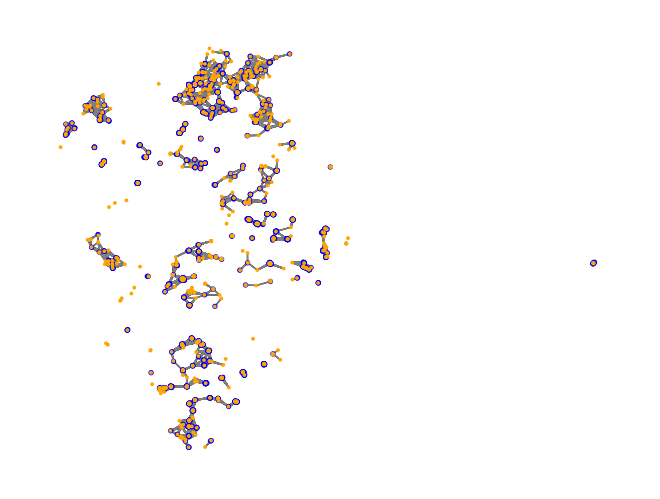

In [807]:
#Graph with distance edge pairs only
nx.draw(combined_graph, combined_pos, node_size=sizes, node_color=colors)
nx.draw_networkx_edges(combined_graph, combined_pos, width=1, edge_color='gray')
plt.show()

In [621]:
#Connect ddb nodes to roundabouts nodes based on maxspeed
maxspeed_edge_pairs = []

maxspeed_ranges = {
    (0, 10): 10,
    (10, 20): 20,
    (20, 40): 40,
    (40, 50): 50,
    (50, 60): 60,
    (60, 70): 70,
    (70, 80): 80
}

def classify_maxspeed(input):
  for key, value in maxspeed_ranges.items():
    if key[0] <= input < key[1]:
      return value
  return None

for i in range(len(ddb_nodes)):
  point, pointspeed = ddb.iloc[i].geometry, ddb.iloc[i].maxspeed

  classifiedspeed = classify_maxspeed(pointspeed)

  dd, ii = tree.query([point.x, point.y], k=20)
  for num in ii:
        distance = haversine_dist(point, roads.iloc[num].geometry)
        print(roads.iloc[num].maxspeed, classifiedspeed)
        if distance <= 500 and roads.iloc[num].maxspeed == classifiedspeed:
           maxspeed_edge_pairs.append((ddb.iloc[i].nodes, roads.iloc[num].nodes, classifiedspeed))
            


40
None 40
None 40
None 40
None 40
None 40
None 40
None 40
None 40
60 40
50 40
60 40
60 40
60 40
60 40
80 40
80 40
80 40
80 40
80 40
80 40
50
60 50
60 50
60 50
None 50
60 50
60 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
50
60 50
60 50
60 50
None 50
60 50
60 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
50
60 50
60 50
60 50
None 50
60 50
60 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
50
60 50
60 50
60 50
None 50
60 50
60 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
None 50
60
None 60
None 60
None 60
None 60
None 60
None 60
60 60
60 60
60 60
None 60
None 60
None 60
None 60
None 60
None 60
None 60
None 60
None 60
60 60
60 60
40
None 40
None 40
None 40
None 40
None 40
None 40
60 40
60 40
60 40
None 40
None 40
None 40
Non

In [809]:
#Connect roundabout to roundabout if they have the same maxspeed limit within 1km
maxspeed_roundabout_only_edge_pairs = []

#maxspeed_roundabout = ['80', '70', '60', '50', '40']

seen = set()

for i in range(len(roundabout_nodes)):
    point = roads.iloc[i].geometry

    dd, ii = tree.query([point.centroid.x, point.centroid.y], k=30)

    for num in ii:
        if roads.iloc[num].nodes != roads.iloc[i].nodes:
          distance = haversine_dist_poly(point, roads.iloc[num].geometry)
          if distance <= 1000 and roads.iloc[i].maxspeed == roads.iloc[num].maxspeed:
            if (roads.iloc[i].nodes, roads.iloc[num].nodes) not in seen and (roads.iloc[num].nodes, roads.iloc[i].nodes) not in seen:
              seen.add((roads.iloc[i].nodes, roads.iloc[num].nodes))
              maxspeed_roundabout_only_edge_pairs.append((roads.iloc[i].nodes, roads.iloc[num].nodes, roads.iloc[i].maxspeed))

combined_graph.add_weighted_edges_from(maxspeed_roundabout_only_edge_pairs)

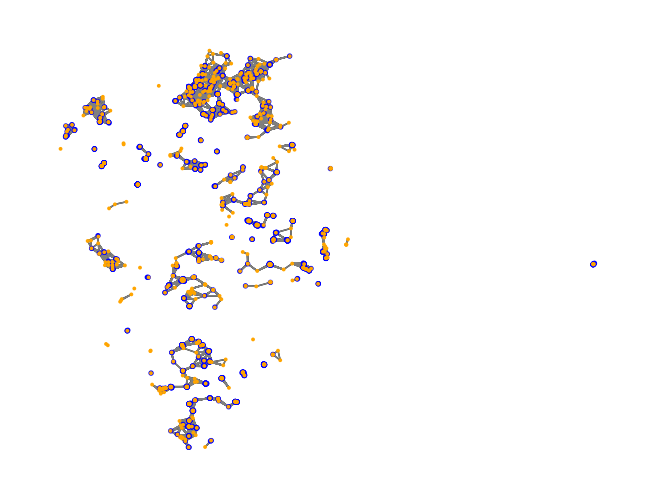

In [813]:
#Graph added with R to R maxspeed
nx.draw(combined_graph, combined_pos, node_size=sizes, node_color=colors)
nx.draw_networkx_edges(combined_graph, combined_pos, width=1, edge_color='gray')
plt.show()

In [543]:
roads['lanes'].unique()

array([None, '2', '1', '3'], dtype=object)

In [558]:
roads['surface'].unique()

array(['concrete', 'paved', 'asphalt', None, 'unpaved'], dtype=object)

In [562]:
roads['highway'].unique()

array([None, 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified',
       'residential', 'service', 'construction'], dtype=object)

Use the roundabout to make one part of the node, the ddb to make another part of the node, and then use the relationship between incident and road to make the edge.

Roads have their own attributes, such as length, width, and number of lanes. Incidents also have certain attributes, such as speed and acceleration.

The relationship between incident and roundabout is distance, nearby arc, and how many kilometers on the road it is.

In [817]:
roads.geometry.area

C:\Users\User\AppData\Local\Temp\ipykernel_75396\577896697.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roads.geometry.area


0      4.741785e-09
1      7.846730e-09
2      3.339455e-09
3      5.958276e-08
4      0.000000e+00
           ...     
899    0.000000e+00
900    0.000000e+00
901    0.000000e+00
902    0.000000e+00
903    0.000000e+00
Length: 904, dtype: float64